In [1]:
import numpy as np
import pandas as pd
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_swiss_roll
import time as time
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import random 
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from cvxopt import matrix
import warnings
warnings.filterwarnings('ignore')

## Reading data_set
### First way:
Reading two data set; 

first is swissroll data set, it is a 1600*3 matrix

second is preswissroll_labels data set, it is a 1600*1 matrix and its swissrolls label.

In [2]:
Data = np.loadtxt('swissroll.dat', unpack = True)
Data = pd.DataFrame(Data).transpose()

Label = np.loadtxt('preswissroll_labels.dat', unpack = True)
Label = pd.DataFrame(Label)

Final_data = pd.concat([Data, Label], axis = 1)
Final_data

,0,1,2,0
0,-5.214647,7.087974,6.729247,1.0
1,-0.421762,8.426638,7.896089,1.0
2,-6.134601,5.686436,6.088567,1.0
3,6.212569,8.307839,2.362335,1.0
4,6.344603,7.664955,0.532386,1.0
...,...,...,...,...
1595,8.503806,13.110051,10.424269,4.0
1596,12.406159,13.831786,-1.233169,4.0
1597,12.440832,12.176057,-1.032280,4.0
1598,9.612878,11.898241,-7.069101,4.0


In [3]:
# Generate data (swiss roll dataset)
n_samples = 1500
noise = 0.05
X, _ = make_swiss_roll(n_samples, noise=noise)
# Make it thinner
X[:, 1] *= .5

In [4]:
# Compute clustering
print("Compute unstructured hierarchical clustering...")
st = time.time()
ward = AgglomerativeClustering(n_clusters=6, linkage='ward').fit(X)
elapsed_time = time.time() - st
label = ward.labels_
print("Elapsed time: %.2fs" % elapsed_time)
print("Number of points: %i" % label.size)

Compute unstructured hierarchical clustering...
Elapsed time: 0.17s
Number of points: 1500


Text(0.5, 0.92, 'Without connectivity constraints (time 0.17s)')

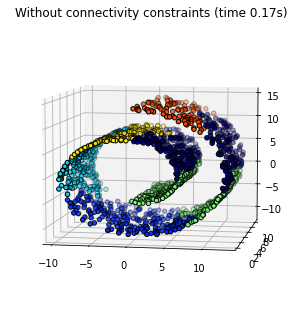

In [5]:
# Plot result
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(7, -80)
for l in np.unique(label):
    ax.scatter(X[label == l, 0], X[label == l, 1], X[label == l, 2],
               color=plt.cm.jet(np.float(l) / np.max(label + 1)),
               s=20, edgecolor='k')
plt.title('Without connectivity constraints (time %.2fs)' % elapsed_time)

### Second way:

Reading the data from data.mat that included with HW file

In [6]:
data = scipy.io.loadmat('data1.mat')
data = np.array(data['data'])
data_frame = pd.DataFrame(data)
data_frame

,0,1,2
0,-937.326653,-924.756951,-926.820633
1,-924.756951,-926.820633,-929.259531
2,-926.820633,-929.259531,-930.947998
3,-929.259531,-930.947998,-930.385176
4,-930.947998,-930.385176,-930.572783
...,...,...,...
11268,739.509146,737.257856,731.817238
11269,737.257856,731.817238,723.937723
11270,731.817238,723.937723,717.371461
11271,723.937723,717.371461,708.929124


### Choose 100 random row:

In [7]:
data1 = data_frame.sample(n = 100, random_state=24)
data = data[np.random.choice(data.shape[0], 100, replace=False), :]
data1

,0,1,2
2788,-1254.383321,-1256.822219,-1256.634611
5065,-1422.854852,-1419.665525,-1422.854852
1215,586.233821,586.984251,587.734681
10375,-838.082288,-841.459223,-842.772475
7871,-200.779624,-199.091157,-197.215082
...,...,...,...
10999,253.042909,251.166834,246.101431
8598,-1025.877391,-1038.259486,-1048.202683
189,-784.051329,-782.175254,-784.989366
7310,-59.135965,-62.137685,-64.764189


In [8]:
def get_distance(x1, x2):
    sum = 0
    for i in range(len(x1)):
        sum += (x1[i] - x2[i]) ** 2
    return np.sqrt(sum)

In [9]:
class RBF:
    def __init__(self, data, radial_basis_function = 'Gaussian', w = None):
        self.data = data
        self.w = w
        self.centroids = None
        self.radial_basis_function = radial_basis_function
        self.std = None

    def convert_to_one_hot(self, x):
        arr = np.zeros((len(x), max(x) + 1))
        for i in range(len(x)):
            c = int(x[i])
            arr[i][c] = 1
        return arr
    
    # Function definition:
    def Gaussian(self, X, centroids, std):
        distance_gaussian = np.linalg.norm(np.array(X) - centroids)
        return 1/np.exp(distance_gaussian / std ** 2)
        
    def Inverse_multiquadratic(self, X, centroids, std):
        distance_multiquadratic = np.linalg.norm(np.array(X) - centroids)
        return 1/np.sqrt((distance_multiquadratic)**2 + std**2)
    
    def Multi_quadratic(self, X, centroids, std):
        distance_quadratic = np.linalg.norm(np.array(X) - centroids)
        return np.sqrt((distance_quadratic)**2 + std**2)
    
    def rbf(self, X, centroids, std):
        f = {'Gaussian': self.Gaussian, 'Inverse_multiquadratic': self.Inverse_multiquadratic, 'Multi_quadratic': self.Multi_quadratic}
        RBF_list = []
        for x in X:
            RBF_list.append([f[self.radial_basis_function](x, c, s) for (c, s) in zip(centroids, std)])
        return RBF_list
    
    def fit(self, X, y, centroids, std):
        self.centroids = centroids
        self.std = std
        RBF_X = np.array(self.rbf(X, self.centroids, self.std))
        self.w = np.dot(np.linalg.pinv(np.dot(np.transpose(RBF_X), RBF_X)), 
                        np.dot(np.transpose(RBF_X), np.array(self.convert_to_one_hot(y))))
        
    def pred(self, X):
        RBF_X = np.array(self.rbf(X, self.centroids, self.std))
        self.pred_y = np.dot(RBF_X, self.w)
        self.pred_y = np.array([np.argmax(y) for y in self.pred_y])
        return self.pred_y
    
    def result(self, X, y):
        self.y = y
        RBF_X = np.array(self.rbf(X, self.centroids, self.std))
        self.pred_y = np.dot(RBF_X, self.w)
        self.pred_y = np.array([np.argmax(y) for y in self.pred_y])
        diff = self.pred_y - self.y
        return (len(np.where(diff == 0)[0]) / len(diff))

# Gaussian
### Split the data:

To examine the impact of the data_set size, we have to initialize different percentage of test_data size and keep the size of train_data the same(for every run)

In general, the percentage of train, val, test sets are: 70%, 20%, 10% (respectively)

We assume to examine the impact of the data_set size, so we initiate a list with the number of smaller and bigger than the original size(Ex: for the test_data_set --> smaller and bigger than 10%)

In [10]:
def Rand(start, end, num): 
    res = [] 
  
    for j in range(num): 
        res.append(random.randint(start, end)) 
        res.sort()  
    return res
# test_percentage = Rand(1, 46, 10)
# val_percentage = Rand(1, 46, 10)


test_percentage = random.sample(range(1, 46), 10)
test_percentage.sort()
test_percentage.reverse()


# n_samples should be >= n_clusters=8. 
# --> therefore the maximum value for test and val percentage are 46 
# --> therefore the minimum value for train percentage is 8

# test_size should be either positive and smaller than the number of samples 54 or a float in the (0, 1) range
# --> therefore the minimum value for test and val percentage are 1 (not 0) 
# --> therefore the maximum value for train percentage is 99

# EX: if test_percentage = [46, 45, 40, 35, 25, 20, 15, 10, 5, 1] 
# --> train_percentage = [99, 90, 80, 70, 50, 40, 30, 20, 10, 8]

train_error = []
val_error = []
test_error = []

for i in test_percentage:
    X_train, X_test = train_test_split(data, test_size=i)
    X_train, X_val = train_test_split(X_train, test_size=i)
        
    # number of classes are 8 because:
    # X_train.shape = (50, 3)
    # y_train.shape = (50,)
    # np.unique(y_train) = array([0, 1, 2, 3, 4, 5, 6, 7]) --> Up to 8 numbers
                
    km = KMeans(n_clusters=8, init='k-means++', n_init=10, max_iter=300, algorithm='auto').fit(X_train)
        
    # Labels of each point
    y_train = km.labels_
        
    # Predict
    y_val = km.predict(X_val)
    y_test = km.predict(X_test)
        
    # If the algorithm stops before fully converging, these will not be consistent with labels_.
    cluster_center = km.cluster_centers_
        
#     print(X_train.shape[0])
#     print(len(y_train))
        
    clusters = {}
    for k in range(0, X_train.shape[0]):
        if not y_train[k] in clusters.keys():
            clusters[y_train[k]] = np.array([X_train[k]])
        else:
            clusters[y_train[k]] = np.append(clusters[y_train[k]],[X_train[k]], axis=0)
    stds = []
    for s in range(min(y_train), max(y_train) + 1):
        stds.append(np.std(clusters[s]))
            
#-------creating object from first class:-----------------------------------------------------------------------------------
    rbf = RBF(data, radial_basis_function='Gaussian')
    rbf.fit(X_train, y_train, cluster_center, stds)
        
    def Average(lst): 
        return sum(lst) / len(lst) 

    train_error.append(mean_squared_error(y_train, rbf.pred(X_train)))
#     tr = Average(train_error)
    val_error.append(mean_squared_error(y_val, rbf.pred(X_val)))
#     va = Average(val_error)
    test_error.append(mean_squared_error(y_test, rbf.pred(X_test)))
#     te = Average(test_error)
        
    print('test_percentage:', i)
    print('train sets accuracy:', rbf.result(X_train, y_train))

    print('validation sets accuracy:', rbf.result(X_val, y_val))

    print('test sets accuracy:', rbf.result(X_test, y_test))
    
    print('--------------------------------------------------------------------------')

test_percentage: 44
train sets accuracy: 1.0
validation sets accuracy: 0.20454545454545456
test sets accuracy: 0.22727272727272727
--------------------------------------------------------------------------
test_percentage: 42
train sets accuracy: 1.0
validation sets accuracy: 0.47619047619047616
test sets accuracy: 0.42857142857142855
--------------------------------------------------------------------------
test_percentage: 37
train sets accuracy: 1.0
validation sets accuracy: 0.7027027027027027
test sets accuracy: 0.6216216216216216
--------------------------------------------------------------------------
test_percentage: 25
train sets accuracy: 1.0
validation sets accuracy: 0.96
test sets accuracy: 1.0
--------------------------------------------------------------------------
test_percentage: 23
train sets accuracy: 1.0
validation sets accuracy: 0.9130434782608695
test sets accuracy: 1.0
--------------------------------------------------------------------------
test_percentage: 22


In [11]:
train_percentage = []
for i in test_percentage :
    v = 100-(i + i)
    train_percentage.append(v)

print('train_percentages are: ', np.array(train_percentage), 
      '\nval_percentages are:   ', np.array(test_percentage),
      '\ntest_percentages are:  ', np.array(test_percentage))

train_percentages are:  [12 16 26 50 54 56 72 74 76 84] 
val_percentages are:    [44 42 37 25 23 22 14 13 12  8] 
test_percentages are:   [44 42 37 25 23 22 14 13 12  8]


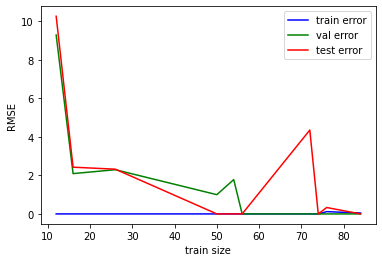

In [12]:
plt.plot(train_percentage, train_error, c='b', label='train error')
plt.plot(train_percentage, val_error, c='g', label='val error')
plt.plot(train_percentage, test_error, c='r', label='test error')
plt.xlabel('train size')
plt.ylabel('RMSE')
plt.legend()
plt.show()

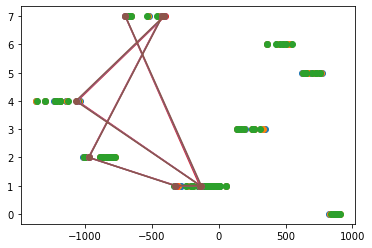

In [13]:
plt.plot(X_train, y_train, 'o', label='true');
plt.plot(X_test, y_test, '-o', label='true');


# Inverse Multiquadratic

In [14]:
def Rand(start, end, num): 
    res = [] 
  
    for j in range(num): 
        res.append(random.randint(start, end)) 
        res.sort()  
    return res
# test_percentage = Rand(1, 46, 10)
# val_percentage = Rand(1, 46, 10)


test1_percentage = random.sample(range(1, 46), 10)
test1_percentage.sort()
test1_percentage.reverse()


# n_samples should be >= n_clusters=8. 
# --> therefore the maximum value for test and val percentage are 46 
# --> therefore the minimum value for train percentage is 8

# test_size should be either positive and smaller than the number of samples 54 or a float in the (0, 1) range
# --> therefore the minimum value for test and val percentage are 1 (not 0) 
# --> therefore the maximum value for train percentage is 99

# EX: if test_percentage = [46, 45, 40, 35, 25, 20, 15, 10, 5, 1] 
# --> train_percentage = [99, 90, 80, 70, 50, 40, 30, 20, 10, 8]

train1_error = []
val1_error = []
test1_error = []

for i in test1_percentage:
    X_train, X_test = train_test_split(data, test_size=i)
    X_train, X_val = train_test_split(X_train, test_size=i)
        
    # number of classes are 8 because:
    # X_train.shape = (50, 3)
    # y_train.shape = (50,)
    # np.unique(y_train) = array([0, 1, 2, 3, 4, 5, 6, 7]) --> Up to 8 numbers
                
    km = KMeans(n_clusters=8, init='k-means++', n_init=10, max_iter=300, algorithm='auto').fit(X_train)
        
    # Labels of each point
    y_train = km.labels_
        
    # Predict
    y_val = km.predict(X_val)
    y_test = km.predict(X_test)
        
    # If the algorithm stops before fully converging, these will not be consistent with labels_.
    cluster_center = km.cluster_centers_
        
#     print(X_train.shape[0])
#     print(len(y_train))
        
    clusters = {}
    for k in range(0, X_train.shape[0]):
        if not y_train[k] in clusters.keys():
            clusters[y_train[k]] = np.array([X_train[k]])
        else:
            clusters[y_train[k]] = np.append(clusters[y_train[k]],[X_train[k]], axis=0)
    stds = []
    for s in range(min(y_train), max(y_train) + 1):
        stds.append(np.std(clusters[s]))
            
#-------creating object from first class:-----------------------------------------------------------------------------------
    rbf = RBF(data, radial_basis_function='Inverse_multiquadratic')
    rbf.fit(X_train, y_train, cluster_center, stds)
        
    def Average(lst): 
        return sum(lst) / len(lst) 

    train1_error.append(mean_squared_error(y_train, rbf.pred(X_train)))
#     tr = Average(train_error)
    val1_error.append(mean_squared_error(y_val, rbf.pred(X_val)))
#     va = Average(val_error)
    test1_error.append(mean_squared_error(y_test, rbf.pred(X_test)))
#     te = Average(test_error)
        
    print('test_percentage:', i)
    print('train sets accuracy:', rbf.result(X_train, y_train))

    print('validation sets accuracy:', rbf.result(X_val, y_val))

    print('test sets accuracy:', rbf.result(X_test, y_test))
    
    print('--------------------------------------------------------------------------')

test_percentage: 42
train sets accuracy: 1.0
validation sets accuracy: 0.5
test sets accuracy: 0.5238095238095238
--------------------------------------------------------------------------
test_percentage: 36
train sets accuracy: 1.0
validation sets accuracy: 0.6666666666666666
test sets accuracy: 0.6666666666666666
--------------------------------------------------------------------------
test_percentage: 32
train sets accuracy: 1.0
validation sets accuracy: 0.90625
test sets accuracy: 0.78125
--------------------------------------------------------------------------
test_percentage: 30
train sets accuracy: 1.0
validation sets accuracy: 0.9666666666666667
test sets accuracy: 0.9333333333333333
--------------------------------------------------------------------------
test_percentage: 28
train sets accuracy: 1.0
validation sets accuracy: 0.8928571428571429
test sets accuracy: 0.9642857142857143
--------------------------------------------------------------------------
test_percentage: 

In [15]:
train1_percentage = []
for i in test1_percentage :
    v = 100-(i + i)
    train1_percentage.append(v)

print('train_percentages are: ', np.array(train1_percentage), 
      '\nval_percentages are:   ', np.array(test1_percentage),
      '\ntest_percentages are:  ', np.array(test1_percentage))

train_percentages are:  [16 28 36 40 44 54 70 84 86 88] 
val_percentages are:    [42 36 32 30 28 23 15  8  7  6] 
test_percentages are:   [42 36 32 30 28 23 15  8  7  6]


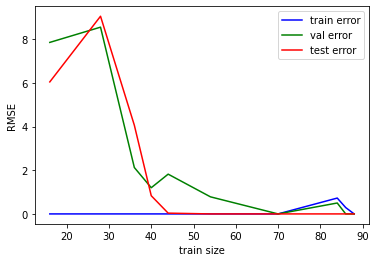

In [16]:
plt.plot(train1_percentage, train1_error, c='b', label='train error')
plt.plot(train1_percentage, val1_error, c='g', label='val error')
plt.plot(train1_percentage, test1_error, c='r', label='test error')
plt.xlabel('train size')
plt.ylabel('RMSE')
plt.legend()
plt.show()

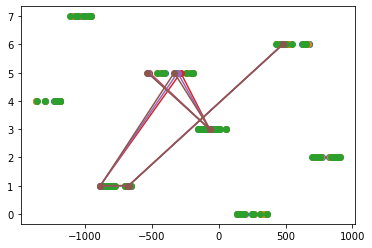

In [17]:
plt.plot(X_train, y_train, 'o', label='true');
plt.plot(X_test, y_test, '-o', label='true');


# Multiquadratic

In [18]:
def Rand(start, end, num): 
    res = [] 
  
    for j in range(num): 
        res.append(random.randint(start, end)) 
        res.sort()  
    return res
# test_percentage = Rand(1, 46, 10)
# val_percentage = Rand(1, 46, 10)


test2_percentage = random.sample(range(1, 46), 10)
test2_percentage.sort()
test2_percentage.reverse()


# n_samples should be >= n_clusters=8. 
# --> therefore the maximum value for test and val percentage are 46 
# --> therefore the minimum value for train percentage is 8

# test_size should be either positive and smaller than the number of samples 54 or a float in the (0, 1) range
# --> therefore the minimum value for test and val percentage are 1 (not 0) 
# --> therefore the maximum value for train percentage is 99

# EX: if test_percentage = [46, 45, 40, 35, 25, 20, 15, 10, 5, 1] 
# --> train_percentage = [99, 90, 80, 70, 50, 40, 30, 20, 10, 8]

train2_error = []
val2_error = []
test2_error = []

for i in test2_percentage:
    X_train, X_test = train_test_split(data, test_size=i)
    X_train, X_val = train_test_split(X_train, test_size=i)
        
    # number of classes are 8 because:
    # X_train.shape = (50, 3)
    # y_train.shape = (50,)
    # np.unique(y_train) = array([0, 1, 2, 3, 4, 5, 6, 7]) --> Up to 8 numbers
                
    km = KMeans(n_clusters=8, init='k-means++', n_init=10, max_iter=300, algorithm='auto').fit(X_train)
        
    # Labels of each point
    y_train = km.labels_
        
    # Predict
    y_val = km.predict(X_val)
    y_test = km.predict(X_test)
        
    # If the algorithm stops before fully converging, these will not be consistent with labels_.
    cluster_center = km.cluster_centers_
        
#     print(X_train.shape[0])
#     print(len(y_train))
        
    clusters = {}
    for k in range(0, X_train.shape[0]):
        if not y_train[k] in clusters.keys():
            clusters[y_train[k]] = np.array([X_train[k]])
        else:
            clusters[y_train[k]] = np.append(clusters[y_train[k]],[X_train[k]], axis=0)
    stds = []
    for s in range(min(y_train), max(y_train) + 1):
        stds.append(np.std(clusters[s]))
            
#-------creating object from first class:-----------------------------------------------------------------------------------
    rbf = RBF(data, radial_basis_function='Multi_quadratic')
    rbf.fit(X_train, y_train, cluster_center, stds)
        
    def Average(lst): 
        return sum(lst) / len(lst) 

    train2_error.append(mean_squared_error(y_train, rbf.pred(X_train)))
#     tr = Average(train_error)
    val2_error.append(mean_squared_error(y_val, rbf.pred(X_val)))
#     va = Average(val_error)
    test2_error.append(mean_squared_error(y_test, rbf.pred(X_test)))
#     te = Average(test_error)
        
    print('test_percentage:', i)
    print('train sets accuracy:', rbf.result(X_train, y_train))

    print('validation sets accuracy:', rbf.result(X_val, y_val))

    print('test sets accuracy:', rbf.result(X_test, y_test))
    
    print('--------------------------------------------------------------------------')

test_percentage: 45
train sets accuracy: 1.0
validation sets accuracy: 0.9555555555555556
test sets accuracy: 0.9777777777777777
--------------------------------------------------------------------------
test_percentage: 42
train sets accuracy: 1.0
validation sets accuracy: 0.9761904761904762
test sets accuracy: 0.9761904761904762
--------------------------------------------------------------------------
test_percentage: 40
train sets accuracy: 1.0
validation sets accuracy: 0.975
test sets accuracy: 1.0
--------------------------------------------------------------------------
test_percentage: 35
train sets accuracy: 1.0
validation sets accuracy: 0.9714285714285714
test sets accuracy: 0.9428571428571428
--------------------------------------------------------------------------
test_percentage: 31
train sets accuracy: 1.0
validation sets accuracy: 0.9354838709677419
test sets accuracy: 1.0
--------------------------------------------------------------------------
test_percentage: 29
tra

In [19]:
train2_percentage = []
for i in test2_percentage :
    v = 100-(i + i)
    train2_percentage.append(v)

print('train_percentages are: ', np.array(train2_percentage), 
      '\nval_percentages are:   ', np.array(test2_percentage),
      '\ntest_percentages are:  ', np.array(test2_percentage))

train_percentages are:  [10 16 20 30 38 42 66 70 76 98] 
val_percentages are:    [45 42 40 35 31 29 17 15 12  1] 
test_percentages are:   [45 42 40 35 31 29 17 15 12  1]


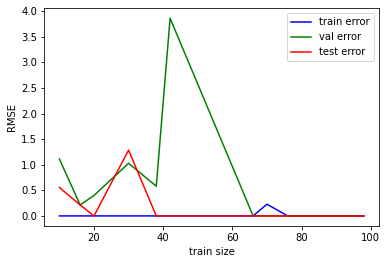

In [20]:
plt.plot(train2_percentage, train2_error, c='b', label='train error')
plt.plot(train2_percentage, val2_error, c='g', label='val error')
plt.plot(train2_percentage, test2_error, c='r', label='test error')
plt.xlabel('train size')
plt.ylabel('RMSE')
plt.legend()
plt.show()

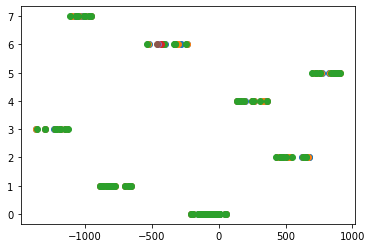

In [22]:
plt.plot(X_train, y_train, 'o', label='true');
plt.plot(X_test, y_test, '-o', label='true');
